<a href="https://colab.research.google.com/github/ayushs0911/Projects/blob/main/X_Ray_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement 
Constructing classification to detect and classify chest diseases and reduce the cost and time of detection. <br>
Provided with 133 images that belong to 4 classes:
- Healthy 
- Covid-19
- Bacterial Pneumonia 
- Viral Pneumonia 


##Significance of Analysis 

- AI/ML/DL has been revolutionizing healthcare and medicine. 
  - Medical Imagery 
  - Drug research 
  - Genome Development 


Deep learning has been proven to be superior in detecting and classifying disease using imagery data. <br>
Skin cancer could be detected more accuratly by Deep learning then by determatologists(2018)
- Human dermatologists detection - 86.6%
- Deep Learning detection - 95%

Reference : "[Computer learns to detect skin cancer more accuratley than doctors", the Guardian. 29 May 2018. ](https://www.theguardian.com/society/2018/may/29/skin-cancer-computer-learns-to-detect-skin-cancer-more-accurately-than-a-doctor)

**This Project include tasks like :**
- Downloading dataset from Google drive 
- Preprocessing image data 
- Constructing a CNN model 
- Constructing Feature Extraction Model 
- Using Data Augmentation 
- Fine-Tuning the model
- Predicting the model on test images

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [53]:
import warnings
warnings.filterwarnings('ignore')

Mounting Google Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_ray = '/content/drive/MyDrive/Datasets/X_Ray.zip'

### Helper Functions
I've made a series of helper functions which can be beneficial in various tasks. So instead of rewriting them again and again, I'll import [helper_functions.py](https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py) file from github

In [4]:
if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists.skipping download.")

--2023-03-18 04:57:24--  https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-18 04:57:25 (73.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import unzip_data, walk_through_dir, plot_loss_curves

In [6]:
#unzipping the data
unzip_data(X_ray)

In [7]:
train_dir = "/content/4. Operations Department/Dataset"

In [8]:
test_dir = "/content/4. Operations Department/Test"

**How many images/classes are there?**


In [9]:
walk_through_dir('4. Operations Department')

There are 2 directories and 1 images in '4. Operations Department'.
There are 4 directories and 0 images in '4. Operations Department/Test'.
There are 0 directories and 10 images in '4. Operations Department/Test/1'.
There are 0 directories and 10 images in '4. Operations Department/Test/3'.
There are 0 directories and 10 images in '4. Operations Department/Test/0'.
There are 0 directories and 10 images in '4. Operations Department/Test/2'.
There are 4 directories and 0 images in '4. Operations Department/Dataset'.
There are 0 directories and 133 images in '4. Operations Department/Dataset/1'.
There are 0 directories and 133 images in '4. Operations Department/Dataset/3'.
There are 0 directories and 133 images in '4. Operations Department/Dataset/0'.
There are 0 directories and 133 images in '4. Operations Department/Dataset/2'.


##Creating data loaders (preparing the data)
Now we've downloaded the data, let's use the `ImageDataGenerator` class along with the `flow_from_directory` method to load in our images.

In [58]:
# use image generator to generate tensor images data and normalize them 
# Using 20% of the data for cross validation 
train_datagen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)


train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               shuffle = True,
                                               subset = 'training')
valid_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = 32, 
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               shuffle = True,
                                               subset = 'validation')
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size = 32,
                                             target_size = (224, 224),
                                             class_mode = 'categorical',
                                             )



Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


Loading in the data we can see we've got 428 images in the training dataset belonging to 4 classes (107 per class) and 40 images in the test set belonging to 4 classes (10 per class).

In [12]:
# Generate a batch of 32 images and labels 
train_images, train_labels = next(train_data)


In [13]:
train_images.shape

(32, 224, 224, 3)

In [14]:
train_labels.shape

(32, 4)

In [15]:
train_labels[:10]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

##Visualising the Dataset

In [17]:
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  #setup target directory
  target_folder = target_dir+target_class

  #get a random image path 
  random_image = random.sample(os.listdir(target_folder), 1)

  #read in image and plot it using matplotlib 
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f"Image shape : {img.shape}")

  return img


Image shape : (630, 700, 3)
Image shape : (897, 1396)
Image shape : (712, 1088)
Image shape : (870, 1110)


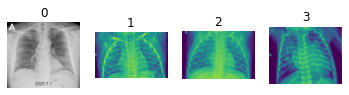

In [18]:
plt.figure()
plt.subplot(1,4,1)
covid = view_random_image('/content/4. Operations Department/Dataset/', '0')

plt.subplot(1,4,2)
covid = view_random_image('/content/4. Operations Department/Dataset/', '1')

plt.subplot(1,4,3)
covid = view_random_image('/content/4. Operations Department/Dataset/', '2')

plt.subplot(1,4,4)
covid = view_random_image('/content/4. Operations Department/Dataset/', '3')



##Creating a CNN Model


In [59]:
model_1 = tf.keras.models.Sequential([
    Conv2D(filters = 10,
           kernel_size =3,
           activation = 'relu',
           input_shape = (224,224,3)),
    MaxPool2D(pool_size = 2, 
              padding = 'valid'),
    Conv2D(10,3,activation = 'relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(4,activation = 'softmax')
])

model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
14/14 [==============================] - 13s 872ms/step - loss: 1.2785 - accuracy: 0.3972 - val_loss: 1.0753 - val_accuracy: 0.5288
Epoch 2/5
14/14 [==============================] - 9s 653ms/step - loss: 0.7744 - accuracy: 0.7710 - val_loss: 0.8023 - val_accuracy: 0.6923
Epoch 3/5
14/14 [==============================] - 9s 594ms/step - loss: 0.5303 - accuracy: 0.8014 - val_loss: 0.5205 - val_accuracy: 0.8077
Epoch 4/5
14/14 [==============================] - 9s 668ms/step - loss: 0.3727 - accuracy: 0.8879 - val_loss: 0.4453 - val_accuracy: 0.8365
Epoch 5/5
14/14 [==============================] - 8s 574ms/step - loss: 0.2996 - accuracy: 0.8972 - val_loss: 0.3991 - val_accuracy: 0.8558


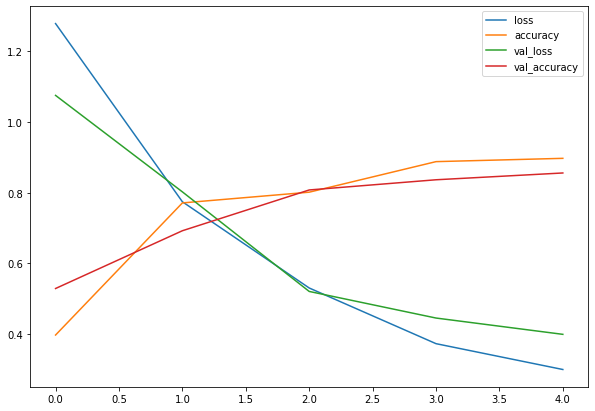

In [60]:
#plot the training curves. 
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

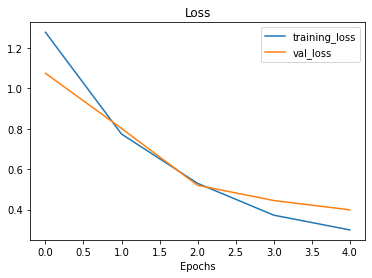

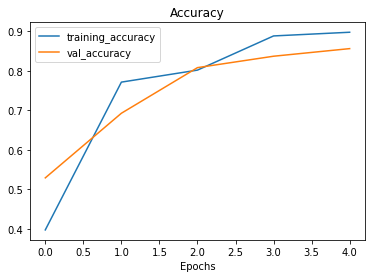

In [61]:
#separating loss and accuracy curve to inspect further
plot_loss_curves(history_1)

In [62]:
model_1_result = model_1.evaluate(test_data)
model_1_result

2/2 [==============================] - 1s 103ms/step - loss: 0.5858 - accuracy: 0.8000


[0.5857948064804077, 0.800000011920929]

##Model 2 : Transfer Learning Model 


Previously we have used `ImageDataGenerator` class, this time we're going to use `image_data_from_directory` function. 

One of the main benefits of using `tf.keras.preprocessing.image_dataset_from_directory()` rather than `ImageDataGenerator` is that it creates `tf.data.Dataset` object rather than a generator. 

In [40]:
IMG_SIZE = (224,224)
train_data_tf = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = 'categorical',
                                                                 batch_size = 32)
test_data_tf = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = 'categorical',
                                                                batch_size = 32)

Found 532 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


In [41]:
train_data_tf,

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>,)

Another benefits of using `tf.data.Dataset` API are the associated methods which come with it. 

For Example : if we want to find the name of classes we were working with, we could use `class_names` attribute. 

In [310]:
class_names = train_data_tf.class_names

class_names

['0', '1', '2', '3']

###Building a Transfer leanring model using Keras Functional API 
We are going to go through following steps 
- Instantiate a pre-trained base model by choosing a target model such as `EfficientNetB0` from `tf.keras.applications`, setting `include_top` parameter to `False` 
- Set base model's `trainable` attribute to `False` to freeze all of the weights in pre-trained model. 
- Define an input layer of model 

In [44]:
# Creating base model with tf.keras.applications 
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

#Freeze the base model (so pre-trained pattersn remain)
base_model.trainable = False

#Create inputs into base model 
inputs = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer')

#If using ResNet50, then we have to add preprocessing layer, not required for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#pass the inputs into base model
x = base_model(inputs)


x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
#output activation layer
outputs = tf.keras.layers.Dense(4, activation = 'softmax')(x)
#combine the inputs with outputs into a model
model_2 = tf.keras.Model(inputs, outputs)

#Compile the model 
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data_tf),
                        validation_data = test_data_tf,
                        validation_steps = len(test_data_tf),
                        )



Epoch 1/5
17/17 [==============================] - 15s 413ms/step - loss: 1.2115 - accuracy: 0.4511 - val_loss: 1.0026 - val_accuracy: 0.7500
Epoch 2/5
17/17 [==============================] - 5s 161ms/step - loss: 0.7812 - accuracy: 0.7914 - val_loss: 0.8468 - val_accuracy: 0.7250
Epoch 3/5
17/17 [==============================] - 4s 163ms/step - loss: 0.6118 - accuracy: 0.8139 - val_loss: 0.7993 - val_accuracy: 0.7250
Epoch 4/5
17/17 [==============================] - 6s 228ms/step - loss: 0.5177 - accuracy: 0.8477 - val_loss: 0.7732 - val_accuracy: 0.7250
Epoch 5/5
17/17 [==============================] - 4s 160ms/step - loss: 0.4821 - accuracy: 0.8421 - val_loss: 0.7526 - val_accuracy: 0.7250


In [45]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_____________________________________________

Our model has 5 layers, but one of those (efficientnetb0) has 236 layers. Also only trainable paramters are in output layer. 

How do our model's curves look?

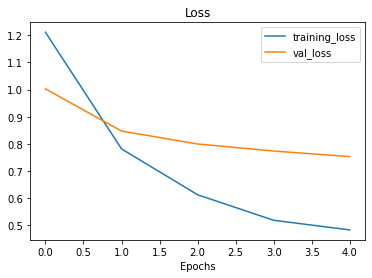

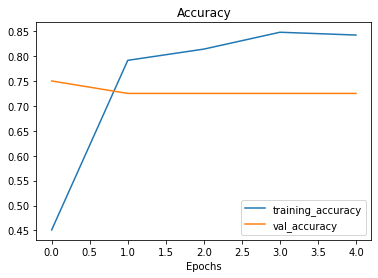

In [46]:
plot_loss_curves(history_2)

In [56]:
model_2_result = model_2.evaluate(test_data)
model_2_result

2/2 [==============================] - 1s 67ms/step - loss: 0.7526 - accuracy: 0.7250


[0.7526298761367798, 0.7250000238418579]

### Adding Data Augmentation into the model 
Data augmentation is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns
To use, well create a Keras Sequential model consisting of only data preprocessing layers, we can then use Sequential model with another Functional model. 



In [63]:
#creating a data augmentation stage with horizontal flipping, rotations, zoom 
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = 'data_augmentation')

##Model 3 : Feature Extraction model with Data Augmentation 

In [64]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(4, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_3 = keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data_tf,
                        epochs = 5,
                        steps_per_epoch = len(train_data_tf),
                        validation_data = test_data_tf,
                        validation_steps = len(test_data_tf))

Epoch 1/5


17/17 [==============================] - 21s 587ms/step - loss: 1.1953 - accuracy: 0.4699 - val_loss: 1.1254 - val_accuracy: 0.6250
Epoch 2/5
17/17 [==============================] - 11s 556ms/step - loss: 0.8875 - accuracy: 0.7030 - val_loss: 0.9594 - val_accuracy: 0.7250
Epoch 3/5
17/17 [==============================] - 10s 526ms/step - loss: 0.7043 - accuracy: 0.7782 - val_loss: 0.8993 - val_accuracy: 0.6750
Epoch 4/5
17/17 [==============================] - 9s 420ms/step - loss: 0.6483 - accuracy: 0.7632 - val_loss: 0.8261 - val_accuracy: 0.7250
Epoch 5/5
17/17 [==============================] - 10s 442ms/step - loss: 0.6144 - accuracy: 0.7951 - val_loss: 0.8045 - val_accuracy: 0.6750


In [65]:
model_3_result = model_3.evaluate(test_data_tf)

2/2 [==============================] - 1s 36ms/step - loss: 0.8045 - accuracy: 0.6750


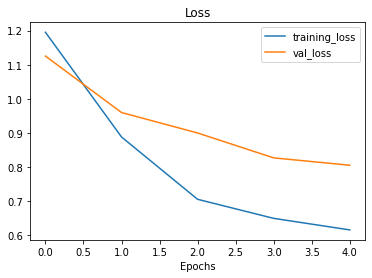

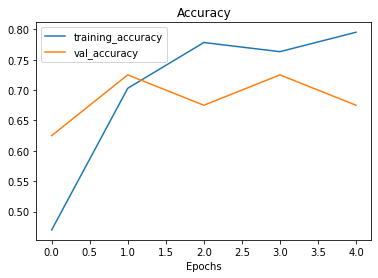

In [66]:
plot_loss_curves(history_3)

## FineTuning a Model 
The idea is to start customizing the pre-trained model more to our own data. <br>
For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and run the model for a few more epochs.

In [67]:
for layer in model_3.layers:
  print(layer.trainable)

True
True
False
True
True


In [68]:
model_3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainab

It looks like all of the layers in `efficientnetb0` are frozen. We can confirm this by :

In [69]:
len(model_3.layers[2].trainable_variables)

0

Now to Fine tune the base model to our own data, we'are going to unfreeze the top 10 layers and continue training our model for another 5 epochs. This means all of the base model's layers except for the last 10 will remain frozen and untrainable. Amd the weights in the remaining unfrizen layers will be updated during training. 

To begin fine-tuning, we'll unfreeze the entire base model by setting its trainable attribute to True. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to False. Finally, we'll recompile the model.

In [72]:
base_model.trainable = True 

for layer in base_model.layers[:-10]:
  layer.trainable = False 

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), #lr is 10x lower than before for fine tuning 
                metrics = ['accuracy'])


We are going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs. 

To do this, using `initial_epochs` parameter of the `fit()` method. We'll pass it the last epoch of the previous model's training history (`history_3.epoch[-1]`)

In [85]:
initial_epochs = 5 #previous model trained for 5
#Fine tune for another 5 epochs 
fine_tune_epochs = initial_epochs + 5

# refitting the model 
history_4 = model_3.fit(train_data_tf, 
                        epochs = fine_tune_epochs,
                        validation_data = test_data_tf,
                        initial_epoch = history_3.epoch[-1],
                        validation_steps = len(test_data_tf))

Epoch 5/10
17/17 [==============================] - 13s 635ms/step - loss: 0.5592 - accuracy: 0.8026 - val_loss: 0.7091 - val_accuracy: 0.7250
Epoch 6/10
17/17 [==============================] - 9s 431ms/step - loss: 0.4669 - accuracy: 0.8233 - val_loss: 0.7868 - val_accuracy: 0.6250
Epoch 7/10
17/17 [==============================] - 10s 471ms/step - loss: 0.4031 - accuracy: 0.8440 - val_loss: 0.7624 - val_accuracy: 0.6250
Epoch 8/10
17/17 [==============================] - 10s 474ms/step - loss: 0.3754 - accuracy: 0.8459 - val_loss: 0.8197 - val_accuracy: 0.6250
Epoch 9/10
17/17 [==============================] - 10s 470ms/step - loss: 0.3023 - accuracy: 0.8929 - val_loss: 1.0727 - val_accuracy: 0.6000
Epoch 10/10
17/17 [==============================] - 9s 398ms/step - loss: 0.2526 - accuracy: 0.9173 - val_loss: 1.1740 - val_accuracy: 0.6000


In [86]:
from helper_functions import compare_historys

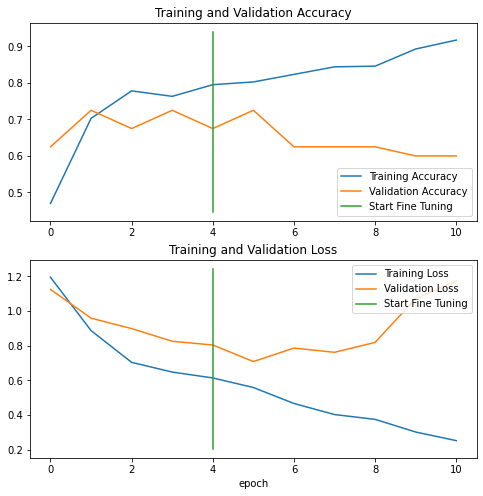

In [87]:
compare_historys(original_history = history_3,
                 new_history = history_4,
                 initial_epochs =5)

In [112]:
model_4_result = model_3.evaluate(test_data_tf)

2/2 [==============================] - 1s 35ms/step - loss: 1.0739 - accuracy: 0.6750


## Let's Train a model with all layers trainable 


In [129]:
#create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = True 

input = layers.Input(shape = input_shape)
x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4)(x)

outputs = layers.Dense(4, activation = 'softmax')(x)
model_all_layers = tf.keras.Model(inputs, outputs)

In [132]:
for layer in model_all_layers.layers:
  print(layer.trainable)

True
True
True
True
True


#### Introducing Callbacks 
- The `EarlyStopping` callback monitors a specified model performance metrics (e.g. `val_loss`) and when it stops improving for a specified number of epochs, it automatically stops training.
- Using `EarlyStopping` callback combined with `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Lets' set both of these upto monitor our model's `val_loss`

We will also use `ReduceLROnPlateau` callback, it monitors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor(e.g. divides the learning rate by 10).

- As training goes on and our model gets closer to it's ideal performance(also called convergence), we want the amount it learns to be less and less.
- For this we'll create an instance of `ReduceLROnPlateau` callback to monitor the validation loss just like `EarlyStopping` callback.
- Once the validation loss stops improving for 2 or more epochs, we'll reduce the learning rate by a factor of 5.

- To make sure learning rate doesn't get too low (and potentially results in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [133]:

#Earylstopping to stop training if model's val_loss doesn't improve for 3 epochs 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 3)

# creating model checkpoint callback to save best model during fine-tuning 
checkpoint_path = 'fine_tune_checkpoints/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = 'val_loss')
# creating learning rate reduction callback 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.2, #multiply learning rate by 0.2 (reduce by 5x)
                                                 patience =2,
                                                 verbose = 1,#print out when learning rate goes down
                                                 min_lr = 1e-7)

Now before we start tuning, we've got to recompile our model.

We'll use sparse categorical crossentropy as loss and since we're fine-tuning, we'll use **10x lower learning rate** than the Adam optimizers default (`1e-4` instead of `1e-3`)

In [134]:
model_all_layers.compile(loss='categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(0.0001),
                         metrics = ['accuracy'])

In [136]:
history_all_layers = model_all_layers.fit(train_data_tf,
                                          epochs = 100,
                                          steps_per_epoch = len(train_data_tf),
                                          validation_data = test_data_tf,
                                          validation_steps = len(test_data_tf),
                                          callbacks = [#model_checkpoint,
                                                       early_stopping,
                                                       reduce_lr])

Epoch 1/100
17/17 [==============================] - 8s 345ms/step - loss: 0.6959 - accuracy: 0.8534 - val_loss: 1.1506 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 2/100
17/17 [==============================] - 7s 288ms/step - loss: 0.4471 - accuracy: 0.9023 - val_loss: 1.0140 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
17/17 [==============================] - 6s 286ms/step - loss: 0.2932 - accuracy: 0.9474 - val_loss: 0.9956 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/100
17/17 [==============================] - 7s 349ms/step - loss: 0.1928 - accuracy: 0.9699 - val_loss: 1.1811 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 5/100
17/17 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9793
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
17/17 [==============================] - 7s 289ms/step - loss: 0.1513 - accuracy: 0.9793 - val_loss: 1.2796 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/100
17/17 [=====================

In [137]:
model_5_result = model_all_layers.evaluate(test_data_tf)

2/2 [==============================] - 1s 39ms/step - loss: 1.3498 - accuracy: 0.5250


#Combining all the Results

In [140]:
results_all = pd.DataFrame({'CNN Model' : model_1_result,
                            'Transfer Learning Model' : model_2_result,
                            'Transfer Learning with Data Augmentation' : model_3_result,
                            'Fine Tuning' : model_4_result,
                            'Model_all_layers_trainable' : model_5_result}, index = ['Loss', 'Accuracy'])

In [141]:
results_all = results_all.T

**Visualising the loss and accuracy of various experiments**


<Axes: >

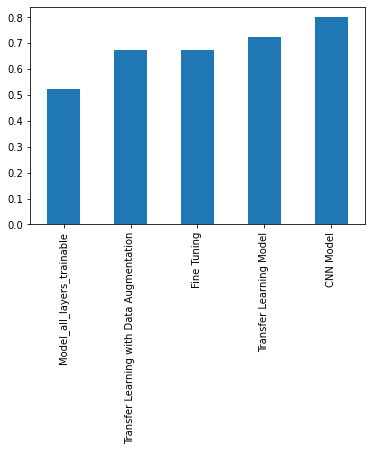

In [145]:
results_all['Accuracy'].sort_values().plot(kind = 'bar')

<Axes: >

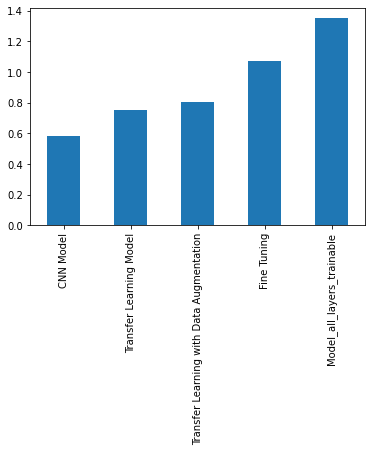

In [148]:
results_all['Loss'].sort_values().plot(kind = 'bar')

###It Seems like Our CNN Model is outperforming other models. 

### Visualizing predictions on test images with CNN Model
As it stands, our model can't just predict on any image of your choice. The image first has to be loaded into a tensor. 

We'll create a function to load an image into a tensor 
- Read in target image file path using `tf.io.read_file()`
- Turn the image into a Tensor using `tf.io.decode_image()`
- Resize the image to be same the same size as the images our model been trained on (224x224) using `tf.image.resize()`
- Scale the image to get all the pixel valyes b/w 0 and 1 necessary.  

In [292]:
def load_and_prep_image(filename, img_shape = 224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)

  img = tf.image.resize(img, [img_shape, img_shape])
  if img.shape[2] == 1:
    img = np.repeat(img, repeats = 3, axis = -1)
  else:
    img = img

  if scale:
    return img/255. 
  else:
    return img 

Image loading and preprocessing function ready. <br>

Now let's some code to 
1. Load a few random images from dataset 
2. Make Predictions on them 
3. Plot the original image along with model's predicted label, prediction probability and ground truth label. 

1/1 [==============================] - 0s 28ms/step


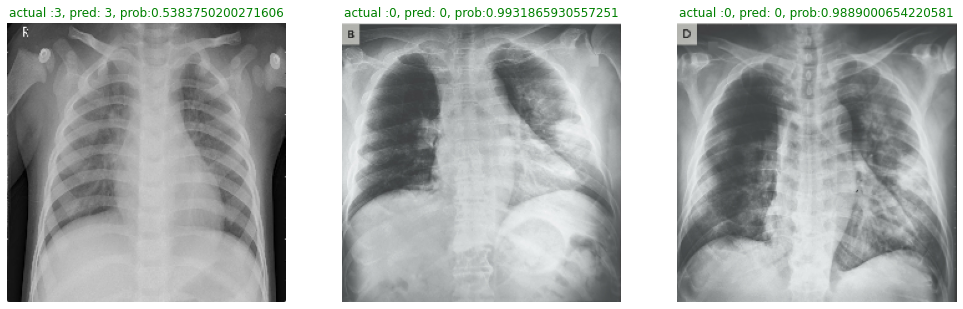

In [312]:
import random

plt.figure(figsize = (17,10))

for i in range(3):
  #choose random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + '/' + class_name + '/' + filename

  #load the image and make prediction 
  img = load_and_prep_image(filepath, scale = True)
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img)
  if class_name == pred_class:
    
    title_color = 'g'
  else:
    title_color = 'r'

  plt.title(f"actual :{class_name}, pred: {pred_class}, prob:{pred_prob.max()}", c=title_color)
  plt.axis(False)

## Our X-Ray Prediction Model is Live